In [15]:
from dataclasses import dataclass
from typing import Any, List

from collections import namedtuple
from snake_egg import EGraph, Rewrite, Var, vars



In [16]:
# Operations
Diff = namedtuple("Diff", "x y")
Integral = namedtuple("Integral", "x y")

Add  = namedtuple("Add", "x y")
Sub  = namedtuple("Sub", "x y")
Mul  = namedtuple("Mul", "x y")
Div  = namedtuple("Div", "x y")
Pow  = namedtuple("Pow", "x y")
Ln   = namedtuple("Ln", "x")
Sqrt = namedtuple("Sqrt", "x")

Sin  = namedtuple("Sin", "x")
Cos  = namedtuple("Cos", "x")

# Allow constant folding via an eval function
def eval_math(car, cdr):
    # This could be a literal encoded in a string
    try:
        return float(car)
    except:
        pass

    # Else it is an operation with arguments
    op = car
    args = cdr
    try:
        a = float(args[0])
        b = float(args[1])
        if op == Add:
            return a + b
        if op == Sub:
            return a - b
        if op == Mul:
            return a * b
        if op == Div and b != 0.0:
            return a / b
    except:
        pass
    return None


# Rewrite rules, not all are currently used since gaurds aren't in snake-egg yet
a, b, c, x, f, g, y = vars("a b c x f g y") # type: ignore
list_rules: List[List[Any]] = [
  # name,        from,               to
  ["comm-add",   Add(a, b),          Add(b, a)],
  ["comm-mul",   Mul(a, b),          Mul(b, a)],
  ["assoc-add",  Add(a, Add(b, c)),  Add(Add(a, b), c)],
  ["assoc-mul",  Mul(a, Mul(b, c)),  Mul(Mul(a, b), c)],

  ["sub-canon",  Sub(a, b),  Add(a, Mul(-1, b))],
  # rw!("div-canon"; "(/ ?a ?b)" => "(* ?a (pow ?b -1))" if is_not_zero("?b")),
  # // rw!("canon-sub"; "(+ ?a (* -1 ?b))"  => "(- ?a ?b)"),
  # // rw!("canon-div"; "(* ?a (pow ?b -1))" => "(/ ?a ?b)" if is_not_zero("?b")),

  ["zero-add",  Add(a, 0),  a],
  ["zero-mul",  Mul(a, 0),  0],
  ["one-mul",   Mul(a, 1),  a],

  ["add-zero",  a,  Add(a, 0)],
  ["mul-one",   a,  Mul(a, 1)],

  ["cancel-sub",  Sub(a, a),  0],
  # rw!("cancel-div"; "(/ ?a ?a)" => "1" if is_not_zero("?a")),

  ["distribute",  Mul(a, Add(b, c)),          Add(Mul(a, b), Mul(a, c))],
  ["factor",      Add(Mul(a, b), Mul(a, c)),  Mul(a, Add(b, c))],

  ["pow-mul",  Mul(Pow(a, b), Pow(a, c)),  Pow(a, Add(b, c))],
  # rw!("pow0"; "(pow ?x 0)" => "1"
  #            if is_not_zero("?x")),
  ["pow1",     Pow(x, 1),                  x],
  ["pow2",     Pow(x, 2),                  Mul(x, x)],
  # rw!("pow-recip"; "(pow ?x -1)" => "(/ 1 ?x)"
  #            if is_not_zero("?x")),
  # rw!("recip-mul-div"; "(* ?x (/ 1 ?x))" => "1" if is_not_zero("?x")),

  # rw!("d-variable"; "(d ?x ?x)" => "1" if is_sym("?x")),
  # rw!("d-constant"; "(d ?x ?c)" => "0" if is_sym("?x") if is_const_or_distinct_var("?c", "?x")),

  ["d-add",  Diff(x, Add(a, b)),  Add(Diff(x, a), Diff(x, b))],
  ["d-mul",  Diff(x, Mul(a, b)),  Add(Mul(a, Diff(x, b)), Mul(b, Diff(x, a)))],

  ["d-sin",  Diff(x, Sin(x)),  Cos(x)],
  ["d-cos",  Diff(x, Cos(x)),  Mul(-1, Sin(x))],

  # rw!("d-ln"; "(d ?x (ln ?x))" => "(/ 1 ?x)" if is_not_zero("?x")),

  # rw!("d-power";
  #     "(d ?x (pow ?f ?g))" =>
  #     "(* (pow ?f ?g)
  #         (+ (* (d ?x ?f)
  #               (/ ?g ?f))
  #            (* (d ?x ?g)
  #               (ln ?f))))"
  #     if is_not_zero("?f")
  #     if is_not_zero("?g")
  # ),

  ["i-one",    Integral(1, x),          x],
  # rw!("i-power-const"; "(i (pow ?x ?c) ?x)" =>
  #            "(/ (pow ?x (+ ?c 1)) (+ ?c 1))" if is_const("?c")),
  ["i-cos",    Integral(Cos(x), x),     Sin(x)],
  ["i-sin",    Integral(Sin(x), x),     Mul(-1, Cos(x))],
  ["i-sum",    Integral(Add(f, g), x),  Add(Integral(f, x), Integral(g, x))],
  ["i-dif",    Integral(Sub(f, g), x),  Sub(Integral(f, x), Integral(g, x))],
  ["i-parts",  Integral(Mul(a, b), x),
               Sub(Mul(a, Integral(b, x)), Integral(Mul(Diff(x, a), Integral(b, x)), x))],
]
# fmt: on

# Turn the lists into rewrites
rules = list()
for l in list_rules:
    name = l[0]
    frm = l[1]
    to = l[2]
    rules.append(Rewrite(frm, to, name))


a = "a"
x = "x"
y = "y"
five = "five"


def is_equal(expr_a, expr_b, iters=5):
    egraph = EGraph(eval_math)

    id_a = egraph.add(expr_a)
    id_b = egraph.add(expr_b)

    egraph.run(rules, iters)

    return egraph.equiv(id_a, id_b)



def test_math_associate_adds():
    expr_a = Add(1, Add(2, Add(3, Add(4, Add(5, Add(6, 7))))))
    expr_b = Add(7, Add(6, Add(5, Add(4, Add(3, Add(2, 1))))))
    assert is_equal(expr_a, expr_b)

def test_math_simplify_add():
    expr_a = Add(x, Add(x, Add(x, x)))
    expr_b = Mul(4, x)
    assert is_equal(expr_a, expr_b)

def test_math_powers():
    expr_a = Mul(Pow(2, x), Pow(2, y))
    expr_b = Pow(2, Add(x, y))
    assert is_equal(expr_a, expr_b)

def test_math_simplify_const():
    expr_a = Add(1, Sub(a, Mul(Sub(2, 1), a)))
    expr_b = 1
    assert is_equal(expr_a, expr_b)

# def test_math_simplify_root():
#     expr_a = div(1, sub(div(add(1, sqrt(five)), 2),
#                         div(sub(1, sqrt(five)), 2)))
#     expr_b = div(1, sqrt(five))
#     assert is_equal(expr_a, expr_b)

def test_math_simplify_factor():
    expr_a = Mul(Add(x, 3), Add(x, 1))
    expr_b = Add(Add(Mul(x, x), Mul(4, x)), 3)
    assert is_equal(expr_a, expr_b)

# def test_math_diff_same():
#     expr_a = diff(x, x)
#     expr_b = 1
#     assert is_equal(expr_a, expr_b)

# def test_math_diff_different():
#     expr_a = diff(x, y)
#     expr_b = 0
#     assert is_equal(expr_a, expr_b)

# def test_math_diff_simple1():
#     expr_a = diff(x, add(1, mul(2, x)))
#     expr_b = 2
#     assert is_equal(expr_a, expr_b)

# def test_math_diff_simple2():
#     expr_a = diff(x, add(1, mul(y, x)))
#     expr_b = y
#     assert is_equal(expr_a, expr_b)

# def test_math_diff_ln():
#     expr_a = diff(x, ln(x))
#     expr_b = div(1, x)
#     assert is_equal(expr_a, expr_b)

# def test_diff_power_simple():
#     expr_a = diff(x, pow(x, 3))
#     expr_b = mul(3, pow(x, 2))
#     assert is_equal(expr_a, expr_b)

# def test_diff_power_harder():
#     expr_a = diff(x, sub(pow(x, 3), mul(7, pow(x, 2))))
#     expr_b = mul(x, sub(mul(3, x), 14))
#     assert is_equal(expr_a, expr_b)

def test_integ_one():
    expr_a = Integral(1, x)
    expr_b = x
    assert is_equal(expr_a, expr_b)

def test_integ_sin():
    expr_a = Integral(Cos(x), x)
    expr_b = Sin(x)
    assert is_equal(expr_a, expr_b)

# def test_integ_x():
#     expr_a = inte(pow(x, 1), x)
#     expr_b = div(pow(x, 2), 2)
#     assert is_equal(expr_a, expr_b)

# def test_integ_part1():
#     expr_a = inte(mul(x, cos(x)), x)
#     expr_b = add(mul(x, sin(x)), cos(x))
#     assert is_equal(expr_a, expr_b)

# def test_integ_part2():
#     expr_a = inte(mul(cos(x), x), x)
#     expr_b = add(mul(x, sin(x)), cos(x))
#     assert is_equal(expr_a, expr_b)

# def test_integ_part3():
#     expr_a = inte(ln(x), x)
#     expr_b = sub(mul(x, ln(x)), x)
#     assert is_equal(expr_a, expr_b)

In [17]:


# Operations
And = namedtuple("And", "x y")
Not = namedtuple("Not", "x")
Or  = namedtuple("Or", "x y")
Implies = namedtuple("Implies", "x y")

# Allow constant folding via an eval function
def eval_prod(car, cdr):

    # This could be a literal
    if type(car) == bool:
        return car

    # Or a variable
    if len(cdr) == 0:
        return None

    # Else it is an operation with arguments
    op = car
    args = cdr

    # Symbolic values cannot be evaluated
    if any(type(a) != bool for a in args):
        return None

    a = args[0]
    if op == Not:
        return not a

    b = args[1]
    if op == And:
        return a and b

    if op == Or:
        return a or b

    if op == Implies:
        return a or not b

    return None


# Rewrite rules
a, b, c = vars("a b c") # type: ignore
list_rules: List[List[Any]] = [
  ["def_imply",        Implies(a, b),                 Or(Not(a), b)],
  ["double_neg",       Not(Not(a)),                   a],
  ["def_imply_flip",   Or(Not(a), b),                 Implies(a, b)],
  ["double_neg_flip",  a,                             Not(Not(a))],
  ["assoc_or",         Or(a, Or(b, c)),               Or(Or(a, b), c)],
  ["dist_and_or",      And(a, Or(b, c)),              Or(And(a, b), And(a, c))],
  ["dist_or_and",      Or(a, And(b, c)),              And(Or(a, b), Or(a, c))],
  ["comm_or",          Or(a, b),                      Or(b, a)],
  ["comm_and",         And(a, b),                     And(b, a)],
  ["lem",              Or(a, Not(a)),                 True],
  ["or_true",          Or(a, True),                   True],
  ["and_true",         And(a, True),                  a],
  ["contrapositive",   Implies(a, b),                 Implies(Not(b), Not(a))],
  ["lem_imply",        And(Implies(a, b), Implies(Not(a), c)),  Or(b, c)],
]
# fmt: on

# Turn the lists into rewrites
rules = list()
for l in list_rules:
    name = l[0]
    frm = l[1]
    to = l[2]
    rules.append(Rewrite(frm, to, name))


def prove_something(start_expr, goal_exprs):
    egraph = EGraph(eval_prod)
    id_start = egraph.add(start_expr)
    egraph.run(rules, 10)
    for i, goal in enumerate(goal_exprs):
        id_goal = egraph.add(goal)
        assert egraph.equiv(id_start, id_goal), "Couldn't prove goal {}: {}".format(
            i, goal
        )


x = "x"
y = "y"
z = "z"


def test_prove_contrapositive():
    prove_something(Implies(x,y),
                    [Implies(x,y),
                        Or(Not(x), y),
                        Or(Not(x), Not(Not(y))),
                        Or(Not(Not(y)), Not(x)),
                        Implies(Not(y), Not(x))])

def test_prove_chain():
    prove_something(And(Implies(x, y), Implies(y, z)),
                    [And(Implies(x, y), Implies(y, z)),
                        And(Implies(Not(y), Not(x)), Implies(y, z)),
                        And(Implies(y, z), Implies(Not(y), Not(x))),
                        Or(z, Not(x)),
                        Or(Not(x), z),
                        Implies(x, z)])

def test_prove_fold():
    prove_something(Or(And(False, True), And(True, False)),
                    [False])


In [18]:
# Define the operations as named tuples
add = namedtuple("add", "x y")
sub = namedtuple("sub", "x y")
mul = namedtuple("mul", "x y")
div = namedtuple("div", "x y")
shll = namedtuple("shll", "x y")  # Bitshift left
shrl = namedtuple("shrl", "x y")  # Bitshift right
not_ = namedtuple("not_", "x")    # Bitwise NOT
neg = namedtuple("neg", "x")      # Negation

# Evaluation function
def eval_ops(car, cdr):
    try:
        if isinstance(car, (int, float)):
            return car

        if len(cdr) == 0:
            return None

        op = car
        args = cdr

        a = args[0]
        if op == not_:
            return ~a
        if op == neg:
            return -a

        b = args[1]
        if op == add:
            return a + b
        if op == sub:
            return a - b
        if op == mul:
            return a * b
        if op == div and b != 0:
            return a / b
        if op == shll:
            return a << b
        if op == shrl:
            return a >> b

    except:
        pass

    return None

# Rewrite rules
a, b, c = vars("a b c")  # Variables for rewrite rules

list_rules: List[List[Any]] = [
    # Basic arithmetic rules
    ["comm_add", add(a, b), add(b, a)],
    ["comm_mul", mul(a, b), mul(b, a)],
    ["zero_add", add(a, 0), a],
    ["zero_mul", mul(a, 0), 0],
    ["one_mul", mul(a, 1), a],
    ["sub_zero", sub(a, 0), a],
    ["neg", neg(a), sub(0, a)],

    # Bitwise rules
    ["shll_zero", shll(a, 0), a],
    ["shrl_zero", shrl(a, 0), a],
    ["not_not", not_(not_(a)), a],
    
    # Dac paper methods
    ["mul_associativity", mul(mul(a, b), c), mul(b, mul(a, c))],
    ["add_associativity", add(add(a, b), c), add(b, add(a, c))],
    ["mul_distributivity", mul(a, add(b, c)), add(mul(a, b), mul(a, c))],
    ["sum_same", add(a, a), mul(a, 2)],
    ["mul_sum_same", add(mul(a, b), b), mul(add(a, 1), b)],
    ["sub_to_neg", sub(a, b), add(a, neg(b))],
    ["mul_by_two", mul(a, 2), shll(a, 1)],
    ["merge_left_shift", shll(shll(a, b), c), shll(a, add(b, c))],
    ["merge_right_shift", shrl(shrl(a, b), c), shrl(a, add(b, c))],
    ["neg_to_not", neg(a), add(not_(a), 1)]
]

# Convert list rules into rewrites
rules = [Rewrite(frm, to, name) for name, frm, to in list_rules]

# Function to check if two expressions are equivalent
def is_equal(expr_a, expr_b, iters=5):
    egraph = EGraph(eval_ops)
    id_a = egraph.add(expr_a)
    id_b = egraph.add(expr_b)
    egraph.run(rules, iters)
    return egraph.equiv(id_a, id_b)

a = "a"
b = "b"
c = "c"

# Test functions
def test_addition_commutative():
    expr_a = add(a, b)
    expr_b = add(b, a)
    assert is_equal(expr_a, expr_b)

def test_bitshift_left_zero():
    expr_a = shll(a, 0)
    expr_b = a
    assert is_equal(expr_a, expr_b)

def test_bitwise_not():
    expr_a = not_(not_(a))
    expr_b = a
    assert is_equal(expr_a, expr_b)

def test_negation():
    expr_a = neg(a)
    expr_b = sub(0, a)
    assert is_equal(expr_a, expr_b)
    
def test_sum_same():
    expr_a = add(a, a)
    expr_b = mul(a, 2)
    assert is_equal(expr_a, expr_b)

def test_mul_sum_same():
    expr_a = add(mul(a, b), b)
    expr_b = mul(add(a, 1), b)
    assert is_equal(expr_a, expr_b)

def test_sub_to_neg():
    expr_a = sub(a, b)
    expr_b = add(a, neg(b))
    assert is_equal(expr_a, expr_b)

def test_mul_by_two():
    expr_a = mul(a, 2)
    expr_b = shll(a, 1)
    assert is_equal(expr_a, expr_b)

def test_merge_left_shift():
    expr_a = shll(shll(a, b), c)
    expr_b = shll(a, add(b, c))
    assert is_equal(expr_a, expr_b)

def test_merge_right_shift():
    expr_a = shrl(shrl(a, b), c)
    expr_b = shrl(a, add(b, c))
    assert is_equal(expr_a, expr_b)

def test_neg_to_not():
    expr_a = neg(a)
    expr_b = add(not_(a), 1)
    assert is_equal(expr_a, expr_b)

def test_mul_associativity():
    expr_a = mul(mul(a, b), c)
    expr_b = mul(b, mul(a, c))
    assert is_equal(expr_a, expr_b)

def test_add_associativity():
    expr_a = add(add(a, b), c)
    expr_b = add(a, add(b, c))
    assert is_equal(expr_a, expr_b)

def test_mul_distributivity():
    expr_a = mul(a, add(b, c))
    expr_b = add(mul(a, b), mul(a, c))
    assert is_equal(expr_a, expr_b)
# Run the new tests

test_addition_commutative()
test_bitshift_left_zero()
test_bitwise_not()
test_negation()
test_sum_same()
test_mul_sum_same()
test_sub_to_neg()
test_mul_by_two()
test_merge_left_shift()
test_merge_right_shift()
test_neg_to_not()
test_mul_associativity()
test_add_associativity()
test_mul_distributivity()
print("All tests passed!")


All tests passed!


In [19]:
# Define the operations as named tuples
add = namedtuple("add", "x y")
sub = namedtuple("sub", "x y")
mul = namedtuple("mul", "x y")
div = namedtuple("div", "x y")
shll = namedtuple("shll", "x y")  # Bitshift left
shrl = namedtuple("shrl", "x y")  # Bitshift right
not_ = namedtuple("not_", "x")    # Bitwise NOT
neg = namedtuple("neg", "x")      # Negation

# Evaluation function
def eval_ops(car, cdr):
    try:
        if isinstance(car, (int, float)):
            return car

        if len(cdr) == 0:
            return None

        op = car
        args = cdr

        a = args[0]
        if op == not_:
            return ~a
        if op == neg:
            return -a

        b = args[1]
        if op == add:
            return a + b
        if op == sub:
            return a - b
        if op == mul:
            return a * b
        if op == div and b != 0:
            return a / b
        if op == shll:
            return a << b
        if op == shrl:
            return a >> b

    except:
        pass

    return None

# Rewrite rules
a, b, c = vars("a b c")  # Variables for rewrite rules

list_rules: List[List[Any]] = [
    # Basic arithmetic rules
    ["comm_add", add(a, b), add(b, a)],
    ["comm_mul", mul(a, b), mul(b, a)],
    ["zero_add", add(a, 0), a],
    ["zero_mul", mul(a, 0), 0],
    ["one_mul", mul(a, 1), a],
    ["sub_zero", sub(a, 0), a],
    ["neg", neg(a), sub(0, a)],

    # Bitwise rules
    ["shll_zero", shll(a, 0), a],
    ["shrl_zero", shrl(a, 0), a],
    ["not_not", not_(not_(a)), a],
    
    # Dac paper methods
    ["mul_associativity", mul(mul(a, b), c), mul(b, mul(a, c))],
    ["add_associativity", add(add(a, b), c), add(b, add(a, c))],
    ["mul_distributivity", mul(a, add(b, c)), add(mul(a, b), mul(a, c))],
    ["sum_same", add(a, a), mul(a, 2)],
    ["mul_sum_same", add(mul(a, b), b), mul(add(a, 1), b)],
    ["sub_to_neg", sub(a, b), add(a, neg(b))],
    ["mul_by_two", mul(a, 2), shll(a, 1)],
    ["merge_left_shift", shll(shll(a, b), c), shll(a, add(b, c))],
    ["merge_right_shift", shrl(shrl(a, b), c), shrl(a, add(b, c))],
    ["neg_to_not", neg(a), add(not_(a), 1)]
]

# Convert list rules into rewrites
rules = [Rewrite(frm, to, name) for name, frm, to in list_rules]

# Function to check if two expressions are equivalent
def is_equal(expr_a, expr_b, iters=5):
    egraph = EGraph(eval_bitwise_ops)
    id_a = egraph.add(expr_a)
    id_b = egraph.add(expr_b)
    egraph.run(rules, iters)
    return egraph.equiv(id_a, id_b)

def get_egraph_in_range(expr, min_iters=0, max_iters=5):
    expr_list = []
    last_iter_expr = None
    # Create an EGraph with the evaluation function
    egraph = EGraph(eval_ops)

    # Add the expression to the e-graph
    expr_id = egraph.add(expr)

    # Run the e-graph with the rewrite rules
    for cur_iters in range(min_iters, max_iters):
        egraph.run(rules, cur_iters)
        cur_expr = egraph.extract(expr_id)
        if last_iter_expr == cur_expr:
            break
        else:
            expr_list.append(cur_expr)
            last_iter_expr = cur_expr

    return expr_list


a = "a"
b = "b"
c = "c"

expr = add(neg(c),add(mul(a, add(b,c)), add(c,c)))

# Example usage
 # Replace with your expression
equivalents = get_egraph_in_range(expr)
for eq in equivalents:
    print(eq)





add(x=neg(x='c'), y=add(x=mul(x='a', y=add(x='b', y='c')), y=add(x='c', y='c')))
add(x=neg(x='c'), y=add(x=mul(x='a', y=add(x='c', y='b')), y=mul(x='c', y=2)))
add(x='c', y=add(x='c', y=add(x=neg(x='c'), y=mul(x='a', y=add(x='c', y='b')))))
add(x=neg(x='c'), y=add(x='c', y=add(x='c', y=mul(x='a', y=add(x='c', y='b')))))


Function: e_graph_test
Batches of nodes: [[11, 10], [36, 35], [9, 8, 7], []]


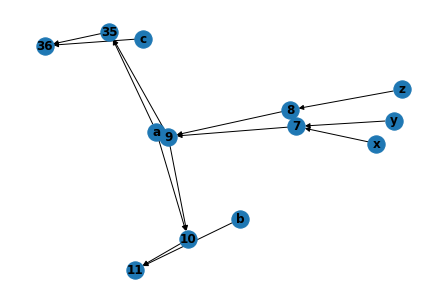

In [31]:
file_path = '/home/miao/xls/work_space/EGraphTest/test.opt.ir'

TopFunctionName = None
with open(file_path, 'r') as f:
    ir_content = f.read()
    ir_dict = slice_ir_by_function(ir_content)

#     print(ir_content)

FuncNodeDict = {}
for fn_name, fn_content in ir_dict.items():
    NodeDict = {}
    Lines = ParseIRFile(fn_content)
    for Line in Lines:    
        NodeList = LineToDict(Line)
        if NodeList != None:
            for NodeObj in NodeList:
                NodeDict[NodeObj.name] = NodeObj
        if "top" in Line:
            TopFunctionName = fn_name
    FuncNodeDict[fn_name] = NodeDict
SubCounter = 0
NodeCounter = 0
JsonOutDict = {}


# print(FuncNodeDict)
sorted_nodes_by_function = {}

for fn_name, fn_nodes in FuncNodeDict.items():
    G = nx.DiGraph()
    G = DictToGraph(G, fn_nodes)
    
    nx.draw(G, with_labels=True, font_weight='bold')
    # Check if the graph is a DAG
    if nx.is_directed_acyclic_graph(G):
        sorted_nodes = list(nx.topological_sort(G))
        sorted_nodes_by_function[fn_name] = sorted_nodes[::-1]
    else:
        print(f"Graph for function {fn_name} is not a DAG. Topological sorting cannot be performed.")

        

rewrite_batch_by_function = {}
processed_nodes = set()

for fn_name, nodes in sorted_nodes_by_function.items():
    rewrite_batch_by_function[fn_name] = []
    
    temp_nodes = nodes.copy()
    while temp_nodes:
        start_node = temp_nodes[0]
        cur_batch = traverse_graph(G, start_node, processed_nodes)
        if cur_batch != []:
            rewrite_batch_by_function[fn_name].append(cur_batch)
            for node in cur_batch:
                processed_nodes.add(node)
                if node in temp_nodes:
                    temp_nodes.remove(node)
        else:
            break

    print(f"Function: {fn_name}")
    print("Batches of nodes:", rewrite_batch_by_function[fn_name])

In [28]:
def remove_entries(operand_list, to_remove):
    return [op for op in operand_list if op not in to_remove]

def traverse_graph(G, start_node, processed_nodes):
    allowed_operations = ["add", "mul", "literal", "shll", "shrl", "not", "neg", "sub", "div"]
    # Initialize the batch list
    batch = []

    # Create a set to keep track of visited nodes
    visited = set()

    # Traverse the graph
    stack = [start_node]
    while stack:
        current = stack.pop()
        current_op_type = G.nodes[current]['OperationType']

        # Check if the current node's operation is allowed
        if current_op_type in allowed_operations:
            # Add the current node to the batch and mark as visited
            batch.append(current)
            visited.add(current)

            for parent in G.predecessors(current):
                # Check if all children of the parent are either visited or disallowed
                all_children_allowed = all(
                    child in visited or G.nodes[child].get('OperationType', None) not in allowed_operations
                    for child in G.successors(parent)
                )

                if all_children_allowed and parent not in processed_nodes and parent not in visited:
                    stack.append(parent)

    return batch

# Example usage with your graph

start_node = 36
path = traverse_graph(G, start_node, [])
print("Traversed path:", path)
print(remove_entries(nodes, path))


Traversed path: [36, 35]
[11, 10, 9, 8, 7, 'c', 'b', 'a', 'z', 'y', 'x']


In [22]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism
import json
import subprocess
import time

In [23]:
class Node:
    def __init__(self, name=None, bitwidth=None, operation=None, operands=None, 
                 idNum=None, value=-1, pos=None, FuncIO=None, start=None, width=None, array_sizes=None, indices=None):
        self.name = name
        self.bitwidth = bitwidth
        self.operation = operation
        self.operands = operands
        self.idNum = idNum
        self.value = value
        self.pos = pos
        self.FuncIO = FuncIO
        self.start = start
        self.width = width
        self.array_sizes = array_sizes
        self.indices = indices

    def __repr__(self):
        return f"Node(name={self.name}, bitwidth={self.bitwidth}, operation={self.operation}, operands={self.operands}, id={self.idNum}, value={self.value}, pos={self.pos}, FuncIO={self.FuncIO}, start={self.start}, width={self.width}, array_sizes={self.array_sizes}, indices={self.indices})"

def node_to_dict(node):
    return {
        "OperationName": node.name,
        "BitWidth": node.bitwidth,
        "OperationType": node.operation,
        "Operands": node.operands,
        "idNum": node.idNum,
        "Value": node.value,
        "Pos": node.pos,
        "FuncIO": node.FuncIO,
        "Start": node.start,
        "Width": node.width,
        "ArraySize": node.array_sizes,
        "Indices": node.indices
    }
    
def ParseIRFile(ir_text):
    nodes_dict = {}
    lines = ir_text.strip().split("\n")[:]
    return lines

def LineToDict(line):
    nodes = []
    # Check for function header
    FuncIO = "Not"
    if "fn" in line:
        FuncIO = "In"
        signature_pattern = re.compile(r"fn\s+(\w+)\((.*?)\)\s*->\s*(.*?)\s*\{")
        signature_match = signature_pattern.search(line)
        if signature_match:
            func_name = signature_match.group(1)
            params = signature_match.group(2).split(',')
            for param in params:
                param_name, param_type = param.split(':')
                param_name = param_name.strip()
                array_sizes = [int(size) for size in re.findall(r'\[(\d+)\]', param_type)]
                if array_sizes == []:
                    array_sizes = None
                bitwidth = int(array_sizes.pop(0))  # The first size is the bitwidth
                node = Node(name=param_name, bitwidth=bitwidth, array_sizes=array_sizes, FuncIO="In")
                nodes.append(node)
        return nodes

    if "ret" in line:
        FuncIO = "Out"
        line = line[4:]
        
    if line == "}":
        return None

    # Extract node name
    name = re.search(r"(\w+\.\d+):", line).group(1)

    # Extract bitwidth and array size
    array_pattern = re.compile(r"bits\[(\d+)\]((?:\[\d+\])*)")
    array_match = array_pattern.search(line)
    if array_match:
        bitwidth = int(array_match.group(1))
        array_sizes_str = array_match.group(2)
        array_sizes = [int(size) for size in re.findall(r'\[(\d+)\]', array_sizes_str)]
        if array_sizes == []:
            array_sizes = None
    
    # Extract operation
    operation = re.search(r"= (\w+)", line).group(1)

    # Extract operands; 
    # Eidt to ignore other argument keywords
    operands = re.findall(r"(\w+\.\d+|\w+)", line.split("=")[1])
    operands = [op for op in operands if op not in [operation, "value", "id", "pos", "start", "width", "indices"]]

    # Extract indices: only applies for array_indice node
    indices = None
    indices_match = re.search(r"indices=\[(.*?)\]", line)
    if indices_match:
        # Get the string of indices
        indices_str = indices_match.group(1)
        # Find all occurrences of literals or node names in the indices string
        indices = re.findall(r"(\w+\.\d+|\w+)", indices_str)
    
    # Extract id
    idNum = int(re.search(r"id=(\d+)", line).group(1))

    # Extract value (if present)
    value_match = re.search(r"value=(\d+)", line)
    value = int(value_match.group(1)) if value_match else -1

    # Extract pos (if present)
    pos_match = re.search(r"pos=\[\((\d+,\d+,\d+)\)\]", line)
    pos = tuple(map(int, pos_match.group(1).split(","))) if pos_match else None

    # Extract start and width for bit_slice (if present)
    start = None
    width = None
    if operation == "bit_slice":
        start = int(re.search(r"start=(\d+)", line).group(1))
        width = int(re.search(r"width=(\d+)", line).group(1))

    # Create Node object
    node = Node(name, bitwidth, operation, operands, idNum, value, pos, FuncIO, start, width, array_sizes, indices)
    
    # Add to node list
    nodes.append(node)
    return nodes

def DictToGraph(G, NodeDict):
    # This function turns the node dictionary to directional graph
    NodeList = []
    EdgeList = []
    for NodeName in NodeDict:
        if NodeDict[NodeName].FuncIO != "In": 
            # This if is for handling the function top input, they are treated as nodes as well.
            NodeList.append((NodeDict[NodeName].idNum, node_to_dict(NodeDict[NodeName])))
            for ParentName in NodeDict[NodeName].operands:
                if NodeDict[ParentName].FuncIO != "In":
                    EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                else: 
                    EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
            if NodeDict[NodeName].indices != None:
                for ParentName in NodeDict[NodeName].indices:
                    if NodeDict[ParentName].FuncIO != "In":
                        EdgeList.append((NodeDict[ParentName].idNum, NodeDict[NodeName].idNum))
                    else: 
                        EdgeList.append((NodeDict[ParentName].name, NodeDict[NodeName].idNum))
        else:
            NodeList.append((NodeDict[NodeName].name, node_to_dict(NodeDict[NodeName])))

    G.add_nodes_from(NodeList)
    G.add_edges_from(EdgeList)
    return G
    
    
def slice_ir_by_function(ir_content):
    # Regular expression to match function definitions with and without "top"
    fn_pattern = re.compile(r"(?:top\s+)?fn\s+(\w+)\((.*?)\)\s*->\s*(.*?)\s*\{")

    # Split the content by lines for processing
    lines = ir_content.split('\n')

    # Dictionary to store each function's IR content
    functions_dict = {}

    # Buffer to store current function lines
    current_fn = None
    current_fn_lines = []

    # Iterate through each line
    for line in lines:
        # Check if the line starts a new function definition
        match = fn_pattern.match(line)
        if match:
            # If there is a current function being processed, save it
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn_lines = []
            # Start a new function
            current_fn = match.group(1)
        # Add the line to the current function's lines
        if current_fn:
            current_fn_lines.append(line)
        # Check if the line ends a function definition
        if line.strip() == '}':
            # Save the current function and reset
            if current_fn:
                functions_dict[current_fn] = '\n'.join(current_fn_lines)
                current_fn = None
                current_fn_lines = []

    # Return the dictionary with function names as keys and IR content as values
    return functions_dict

